# Sales Forecasting Description

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from lightgbm import LGBMRegressor

In [35]:
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = pd.merge(train, features, on=["Store", "Date", "IsHoliday"], how="left")
data = pd.merge(data, stores, on="Store", how="left")
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [36]:
data.isnull().sum()
for col in data.select_dtypes(include=['float64','int64']).columns:
    data[col] = data[col].fillna(data[col].median())

In [37]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekOfYear'] = data['Date'].dt.isocalendar().week.astype(int)
data['DayOfWeek'] = data['Date'].dt.weekday  
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)
data = data.sort_values(by=['Store', 'Date'])
for lag in [1, 7, 14]:  
    data[f'Weekly_Sales_lag{lag}'] = data.groupby('Store')['Weekly_Sales'].shift(lag)
for window in [7, 14, 30]:
    data[f'Weekly_Sales_rollmean_{window}'] = data.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=window).mean().reset_index(level=0, drop=True)
    data[f'Weekly_Sales_rollstd_{window}'] = data.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=window).std().reset_index(level=0, drop=True)
data = data.dropna().reset_index(drop=True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,IsWeekend,Weekly_Sales_lag1,Weekly_Sales_lag7,Weekly_Sales_lag14,Weekly_Sales_rollmean_7,Weekly_Sales_rollstd_7,Weekly_Sales_rollmean_14,Weekly_Sales_rollstd_14,Weekly_Sales_rollmean_30,Weekly_Sales_rollstd_30
0,1,16,2010-02-05,10217.55,False,42.31,2.572,5347.45,192.0,24.6,...,0,19466.91,40129.01,24924.50,82732.230000,37219.189008,51092.704286,42221.291232,27623.738667,36832.456618
1,1,17,2010-02-05,13223.76,False,42.31,2.572,5347.45,192.0,24.6,...,0,10217.55,16930.99,50605.27,66233.298571,36492.299094,45247.725714,36456.925729,26038.015000,31456.517903
2,1,18,2010-02-05,4729.50,False,42.31,2.572,5347.45,192.0,24.6,...,0,13223.76,30721.50,13740.12,82672.718571,35542.891282,51874.424286,41181.044684,28198.225667,36489.182521
3,1,19,2010-02-05,1947.05,False,42.31,2.572,5347.45,192.0,24.6,...,0,4729.50,24213.18,39954.04,22702.748571,34749.457448,12869.487143,25762.793605,12156.520333,18619.455949
4,1,20,2010-02-05,5034.10,False,42.31,2.572,5347.45,192.0,24.6,...,0,1947.05,8449.54,32229.38,22473.304286,30679.103538,13424.302857,22981.515179,14257.908000,17635.978031


In [38]:
data.duplicated().sum()

np.int64(0)

In [39]:
data.isnull().sum()

Store                       0
Dept                        0
Date                        0
Weekly_Sales                0
IsHoliday                   0
Temperature                 0
Fuel_Price                  0
MarkDown1                   0
MarkDown2                   0
MarkDown3                   0
MarkDown4                   0
MarkDown5                   0
CPI                         0
Unemployment                0
Type                        0
Size                        0
Year                        0
Month                       0
Day                         0
WeekOfYear                  0
DayOfWeek                   0
IsWeekend                   0
Weekly_Sales_lag1           0
Weekly_Sales_lag7           0
Weekly_Sales_lag14          0
Weekly_Sales_rollmean_7     0
Weekly_Sales_rollstd_7      0
Weekly_Sales_rollmean_14    0
Weekly_Sales_rollstd_14     0
Weekly_Sales_rollmean_30    0
Weekly_Sales_rollstd_30     0
dtype: int64

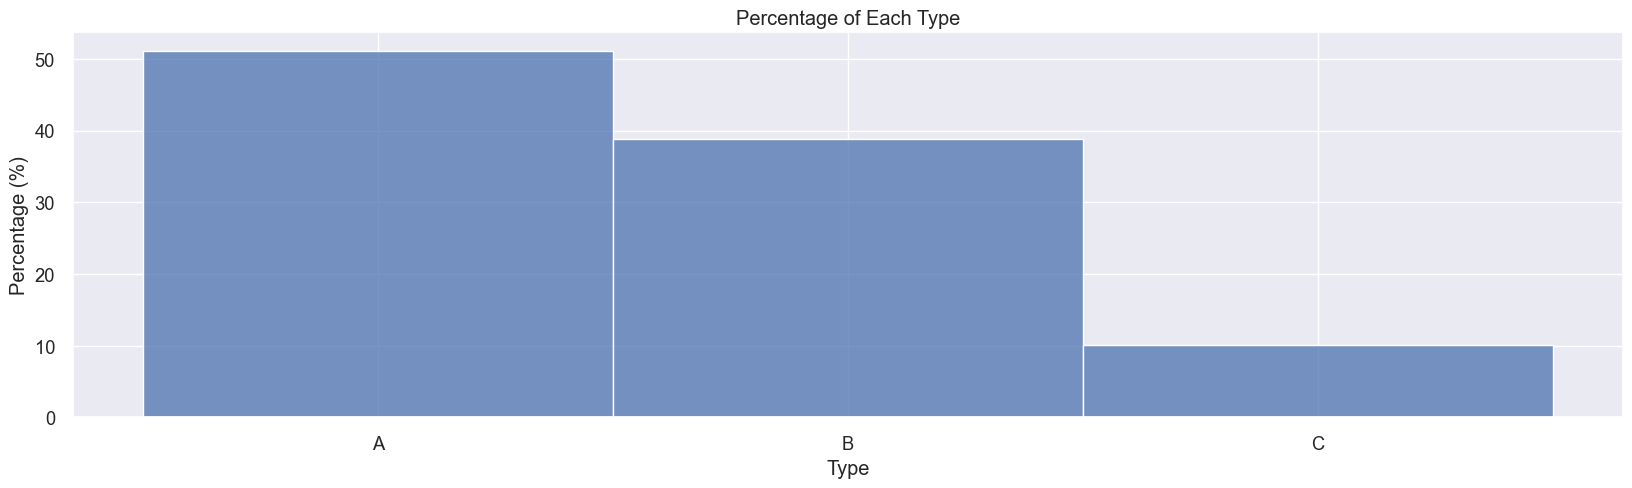

In [40]:
plt.figure(figsize=(20,5))
sns.histplot(data["Type"], stat='percent', discrete=True)
plt.title("Percentage of Each Type")
plt.xlabel("Type")
plt.ylabel("Percentage (%)")
plt.show()

In [41]:
def label_encode_dataframe(df):
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
        df_encoded[col] = le.fit_transform(df_encoded[col])
    return df_encoded
encoded = label_encode_dataframe(data)

In [42]:
X = encoded.drop(columns=['Weekly_Sales', 'Date'])  
y = encoded['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
dates_test = data.loc[y_test.index, 'Date']

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [44]:
print("Linear Regression:")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2  :", r2_score(y_test, y_pred_lr))

Linear Regression:
MAE : 10142.604091952766
RMSE: 16592.758182332895
R2  : 0.2081145016379845


In [45]:
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [46]:
print("\nXGBoost Regressor:")
print("MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R2  :", r2_score(y_test, y_pred_xgb))


XGBoost Regressor:
MAE : 5716.183408719861
RMSE: 8987.854314397599
R2  : 0.7676528924052386


In [47]:
lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4838
[LightGBM] [Info] Number of data points in the train set: 335708, number of used features: 27
[LightGBM] [Info] Start training from score 16776.951255


In [48]:
print("\nLightGBM Regressor:")
print("MAE :", mean_absolute_error(y_test, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
print("R2  :", r2_score(y_test, y_pred_lgbm))


LightGBM Regressor:
MAE : 5600.459737774577
RMSE: 8880.258330592133
R2  : 0.7731825719589386


In [49]:
last_row = X.iloc[[-1]]  
print("\nForecast for Next Period:")
print("Linear Regression:", lr.predict(last_row)[0])
print("XGBoost          :", xgb_model.predict(last_row)[0])
print("LightGBM         :", lgbm.predict(last_row)[0])


Forecast for Next Period:
Linear Regression: 12869.042780461721
XGBoost          : 237.52463
LightGBM         : 1444.3917552753696


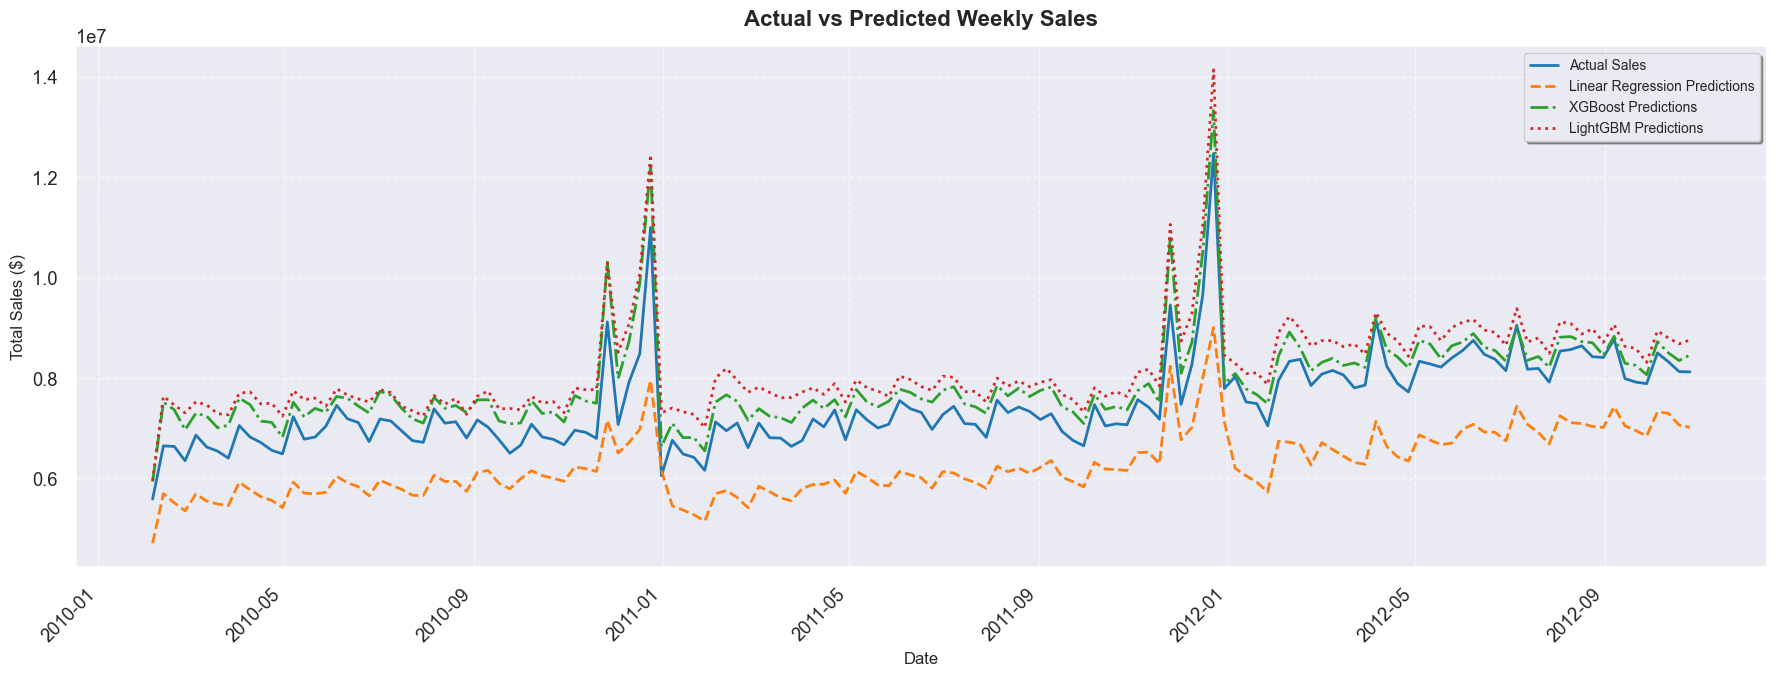

In [50]:
plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.2)
agg_actual = data.loc[X_test.index].groupby('Date')['Weekly_Sales'].sum()
agg_pred_lr = pd.Series(y_pred_lr, index=dates_test).groupby('Date').sum()
agg_pred_xgb = pd.Series(y_pred_xgb, index=dates_test).groupby('Date').sum()
agg_pred_lgbm = pd.Series(y_pred_lgbm, index=dates_test).groupby('Date').sum()
plt.figure(figsize=(18, 7))
plt.plot(agg_actual.index, agg_actual, label='Actual Sales', color='#1f77b4', linewidth=2)
plt.plot(agg_pred_lr.index, agg_pred_lr, label='Linear Regression Predictions', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(agg_pred_xgb.index, agg_pred_xgb, label='XGBoost Predictions', color='#2ca02c', linestyle='-.', linewidth=2)
plt.plot(agg_pred_lgbm.index, agg_pred_lgbm, label='LightGBM Predictions', color='#d62728', linestyle=':', linewidth=2)
plt.title('Actual vs Predicted Weekly Sales', fontsize=16, weight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(loc='best', fontsize=10, frameon=True, shadow=True)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()